# Monte Carlo to compute option price

Goal: To discount risk-free rates and account for stock market volatility in computing option price and compare it with real value of option price

In [1]:
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

## Important concepts
- A call option is of higher value in driving up markets
- A put option is of higher value in driving down markets
- Higher volatility drives a higher option price. Market instability makes a call/put option valuable.
- A higher rick-free rate goes hand in hand with interest/return. This increases the cost of capital making the option price higher..
- The higher the number of simulations the more accurate, yet this has a time tradeoff.

In [60]:
S = 101.15      # stock price ($)
K = 98.01       # strike price ($)
vol = 0.0991    # volatility (%)
r = 0.01        # risk-free rate (%)
N = 10          # number of time steps
M = 10000        # number of simulations

market_value = 3.86 # TBD: compare to predicted value using monte carlo
# strike at Jan 15. Exercise at March 17
T = ((  datetime.date(2022,3,14) - datetime.date(2022, 1, 14)).days+1)/365 #time in years
print(T) # 0.1643835616438356


0.1643835616438356


# Use vectors and space for a faster algorithm

In [63]:
# precompute constants
dt = T/N
nudt = (r-0.5*vol**2) * dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Method
Z = np.random.normal(size=(N,M))
delta_lnSt = nudt + volsdt*Z
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate((np.full(shape=(1,M), fill_value=lnS), lnSt))

# compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST-K)
C0 = np.exp(-r*T) * np.sum(CT[-1])/M

sigma = np.sqrt(np.sum((CT[-1] - C0)**2) / (M-1))
SE = sigma/np.sqrt(M)

print('Call value is ${0} with SE +/- {1}'.format(np.round(C0, 2), np.round(SE,2)))

Call value is $3.84 with SE +/- 0.03


# Visualization

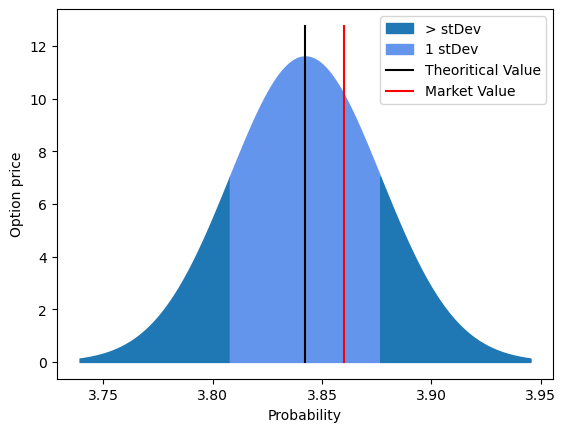

In [64]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)

plt.fill_between(x1,s1, color='tab:blue', label = '> stDev')
plt.fill_between(x2,s2, color='cornflowerblue', label = '1 stDev')
plt.fill_between(x3,s3, color='tab:blue')

plt.plot([C0, C0], [0, max(s2) * 1.1], 'k', label ='Theoritical Value')
plt.plot([market_value, market_value], [0, max(s2) * 1.1], 'r', label ='Market Value')

plt.xlabel('Probability')
plt.ylabel('Option price')
plt.legend()
plt.show()